In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Kaggle 필사

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.5 MB/s eta 0:00:00


In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [5]:
import numpy
print(numpy.__version__)

2.0.2


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(offline=True, world_readable=True)

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"

from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [7]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',900)

pd.set_option('display.max_colwidth',200)

df=pd.read_csv('/content/drive/MyDrive/EURON/test/heart.csv.xls')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
def missing (df):
  missing_number=df.isnull().sum().sort_values(ascending=False)
  missing_percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_values=pd.concat([missing_number,missing_percent],axis=1,keys=['Missing_Number','Missing_Percent'])

  return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [11]:
numerical=df.drop(['HeartDisease'],axis=1).select_dtypes('number').columns

categorical=df.select_dtypes('object').columns

print(f'Numerical Columns: {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [12]:
df[categorical].nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


In [13]:
y=df['HeartDisease']
print(f'Percentage of patient had a HeartDisease: {round(y.value_counts(normalize=True)[1]*100,2)} % --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)} % --> ({y.value_counts()[0]} patient)')

Percentage of patient had a HeartDisease: 55.34 % --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66 % --> (410 patient)


In [14]:
import plotly.express as px
px.histogram(df, x='HeartDisease')


In [15]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [16]:
px.histogram(df, x=numerical)

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


rows = len(numerical)
fig = make_subplots(rows=rows, cols=1, shared_xaxes=False,
                    subplot_titles=numerical)

for i, col in enumerate(numerical):
    fig.add_trace(
        go.Histogram(x=df[col], nbinsx=50, name=col),
        row=i+1, col=1
    )

fig.update_layout(height=300*rows, title_text='Histograms of Numerical Features')
fig.show()


In [18]:
skew_limit=0.75
skew_vals=df[numerical].drop('FastingBS',axis=1).skew()
skew_cols=skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

,0
Oldpeak,1.022872


<Axes: >

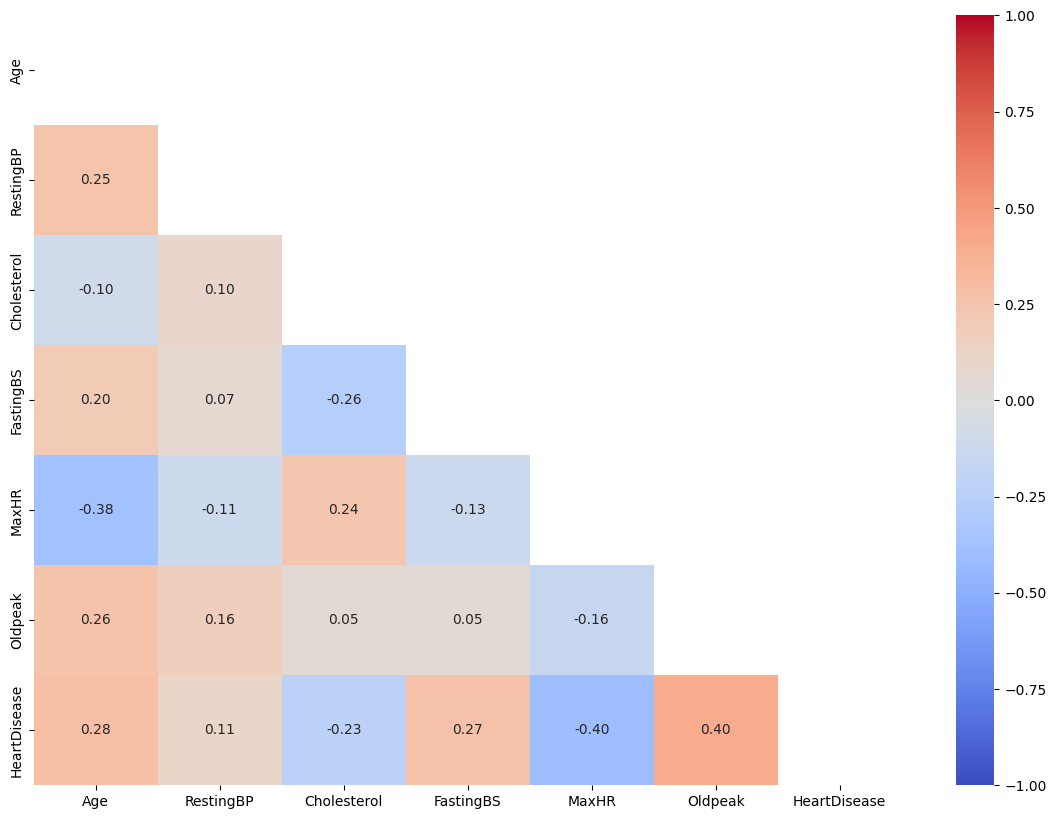

In [19]:
numerical1=df.select_dtypes('number').columns

matrix=np.triu(df[numerical1].corr())
fig,ax=plt.subplots(figsize=(14,10))
sns.heatmap(df[numerical1].corr(),annot=True,fmt='.2f',vmin=-1,vmax=1,center=0,cmap='coolwarm',mask=matrix,ax=ax)

In [20]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [21]:
print(f"A female person has a probability of {round(df[df['Sex']=='F']['HeartDisease'].mean()*100,2)} % have a HeartDisease")

print()

print(f"A male person has a probability of {round(df[df['Sex']=='M']['HeartDisease'].mean()*100,2)} % have a HeartDisease")

print()

A female person has a probability of 25.91 % have a HeartDisease

A male person has a probability of 63.17 % have a HeartDisease



In [22]:
fig=px.histogram(df,x='Sex',color='HeartDisease',width=400,height=400)
fig.show()

In [23]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ChestPainType,
ASY,0.790323
TA,0.434783
NAP,0.354680
ATA,0.138728


In [24]:
fig=px.histogram(df,x='ChestPainType',color='HeartDisease',width=400,height=400)
fig.show()

In [25]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
RestingECG,
ST,0.657303
LVH,0.563830
Normal,0.516304


In [26]:
fig=px.histogram(df,x='RestingECG',color='HeartDisease',width=400,height=400)
fig.show()

In [27]:
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ExerciseAngina,
Y,0.851752
N,0.351005


In [28]:
fig=px.histogram(df,x='ExerciseAngina',color='HeartDisease',width=400,height=400)
fig.show()

In [29]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ST_Slope,
Flat,0.828261
Down,0.777778
Up,0.197468


In [30]:
fig=px.histogram(df,x='ST_Slope',color='HeartDisease',width=400,height=400)
fig.show()

Model Selection

In [31]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

ohe=OneHotEncoder()
ct=make_column_transformer((ohe,categorical),remainder='passthrough')

model=DummyClassifier(strategy='constant',constant=1)
pipe=make_pipeline(ct,model)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test,y_pred),4))
print(f'model:{model} and accuracy score is : {round(accuracy_score(y_test,y_pred),4)}')

model_names=['DummyClassifier']
dummy_result_df=pd.DataFrame({'Accuracy':accuracy},index=model_names)
dummy_result_df

model:DummyClassifier(constant=1, strategy='constant') and accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


In [32]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

ohe=OneHotEncoder()
ct=make_column_transformer((ohe,categorical),remainder='passthrough')


lr=LogisticRegression(solver='liblinear')
lda=LinearDiscriminantAnalysis()
svm=SVC(gamma='scale')
knn=KNeighborsClassifier()

models=[lr,lda,svm,knn]

for model in models:
  pipe=make_pipeline(ct,model)
  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test,y_pred),4))
  print(f'model:{model} and accuracy score is : {round(accuracy_score(y_test,y_pred),4)}')

model_names=['Logistic','LinearDiscriminant','SVM','KNeighbors']

result_df1=pd.DataFrame({'Accuracy':accuracy},index=model_names)
result_df1

model:LogisticRegression(solver='liblinear') and accuracy score is : 0.8841
model:LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model:SVC() and accuracy score is : 0.7246
model:KNeighborsClassifier() and accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


In [33]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

ohe=OneHotEncoder()
s=StandardScaler()

categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


ct1=make_column_transformer((ohe,categorical),(s,numerical))


lr=LogisticRegression(solver='liblinear')
lda=LinearDiscriminantAnalysis()
svm=SVC(gamma='scale')
knn=KNeighborsClassifier()

models=[lr,lda,svm,knn]

for model in models:
  pipe=make_pipeline(ct1,model)
  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test,y_pred),4))
  print(f'model:{model} and accuracy score is : {round(accuracy_score(y_test,y_pred),4)}')

model_names=['Logistic_scl','LinearDiscriminant_scl','SVM_scl','KNeighbors_scl']

result_df2=pd.DataFrame({'Accuracy':accuracy},index=model_names)
result_df2

model:LogisticRegression(solver='liblinear') and accuracy score is : 0.8804
model:LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model:SVC() and accuracy score is : 0.8841
model:KNeighborsClassifier() and accuracy score is : 0.8841


,Accuracy
Logistic_scl,0.8804
LinearDiscriminant_scl,0.8696
SVM_scl,0.8841
KNeighbors_scl,0.8841


In [34]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

ohe=OneHotEncoder()
ct=make_column_transformer((ohe,categorical),remainder='passthrough')


ada=AdaBoostClassifier(random_state=0)
gb=GradientBoostingClassifier(random_state=0)
rf=RandomForestClassifier(random_state=0)
et=ExtraTreesClassifier(random_state=0)

models=[ada,gb,rf,et]

for model in models:
  pipe=make_pipeline(ct,model)
  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test,y_pred),4))
  print(f'model:{model} and accuracy score is : {round(accuracy_score(y_test,y_pred),4)}')

model_names=['Ada','Gradient','Random','ExtraTree']

result_df3=pd.DataFrame({'Accuracy':accuracy},index=model_names)
result_df3

model:AdaBoostClassifier(random_state=0) and accuracy score is : 0.8732
model:GradientBoostingClassifier(random_state=0) and accuracy score is : 0.8768
model:RandomForestClassifier(random_state=0) and accuracy score is : 0.8877
model:ExtraTreesClassifier(random_state=0) and accuracy score is : 0.8804


,Accuracy
Ada,0.8732
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


In [35]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

ohe=OneHotEncoder()
ct=make_column_transformer((ohe,categorical),remainder='passthrough')

xgbc=XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)

models=[xgbc,lgbmc]

for model in models:
  pipe=make_pipeline(ct,model)
  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test,y_pred),4))
  print(f'model:{model} and accuracy score is : {round(accuracy_score(y_test,y_pred),4)}')

model_names=['XGBoost','LightGBM']

result_df4=pd.DataFrame({'Accuracy':accuracy},index=model_names)
result_df4

model:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...) and accuracy score is : 0.8478
[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to 

,Accuracy
XGBoost,0.8478
LightGBM,0.8732


In [36]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5

,Accuracy
Catboost_default,0.8804


In [37]:
def objective(trial):
  X=df.drop('HeartDisease',axis=1)
  y=df['HeartDisease']
  categorical_features_indices=np.where(X.dtypes != float)[0]

  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

  param={"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),"used_ram_limit": "3gb",}

  if param['bootstrap_type']=='Bayesian':
          param['bagging_temperature']=trial.suggest_float('bagging_temperature',0,10)
  elif param['bootstrap_type']=='Bernoulli':
          param['subsample']=trial.suggest_float('subsample',0.1,1)

  cat_cls=CatBoostClassifier(**param)

  cat_cls.fit(X_train,y_train,eval_set=[(X_test,y_test)],cat_features=categorical_features_indices,verbose=0,early_stopping_rounds=100)

  preds=cat_cls.predict(X_test)
  pred_labels=np.rint(preds)
  accuracy=accuracy_score(y_test,pred_labels)
  return accuracy

if __name__=="__main__":
  study=optuna.create_study(direction='maximize')
  study.optimize(objective,n_trials=50,timeout=600)

  print("Number of finished trials: {}".format(len(study.trials)))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: {}".format(trial.value))

  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))



[I 2025-04-29 07:47:44,239] A new study created in memory with name: no-name-a36d349b-0776-4ee3-a652-5d3f400523c6
[I 2025-04-29 07:47:47,015] Trial 0 finished with value: 0.8913043478260869 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.014678549720157147, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-04-29 07:47:54,109] Trial 1 finished with value: 0.8840579710144928 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09237570200304467, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4920645886670527}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-04-29 07:48:01,666] Trial 2 finished with value: 0.8768115942028986 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012755230300550844, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.90756691356562}. Best is trial 0 with val

Number of finished trials: 50
Best trial:
  Value: 0.9021739130434783
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.046290270717191634
    depth: 9
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.4490092731474298


In [38]:
accuracy=[]
model_names=[]

X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']
categorical_features_indices=np.where(X.dtypes!=float)[0]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

model=CatBoostClassifier(verbose=False,random_state=0,objective='CrossEntropy',colsample_bylevel=0.04292240490294766, depth=10,boosting_type='Plain',bootstrap_type='MVS')

model.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=(X_test,y_test))
y_pred=model.predict(X_test)
accuracy.append(round(accuracy_score(y_test,y_pred),4))
print(classification_report(y_test,y_pred))

model_names=['Catboost_tuned']
result_df6=pd.DataFrame({'Accuracy':accuracy},index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9094


In [42]:
feature_importance=np.array(model.get_feature_importance())
features=np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi=pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'],ascending=True,inplace=True)
fig=px.bar(df_fi,x='feature_importance',y='features',title='CatBoost Feature Importance',height=500)
fig.show()

In [43]:
result_final=pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)

In [44]:
result_final.sort_values(by=['Accuracy'],ascending=True,inplace=True)
fig=px.bar(result_final,x='Accuracy',y=result_final.index,title='Model Comparision',height=600,labels={'index':'MODELS'})
fig.show()